In [34]:
!module load python/3.6
import sys
# load your python virtual environment
sys.path.append("/home/u17/jiachuanxu/python3.6_virtualenv/lib/python3.6/site-packages")
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [35]:
def cov2cor(covs):
    cors = []
    for cov in covs:
        Ni, Nj = cov.shape[0], cov.shape[1]
        cor = np.zeros(cov.shape)
        for i in range(Ni):
            for j in range(Nj):
                if(cov[i,i] * cov[j,j] > 0):
                    cor[i,j] = cov[i,j] / np.sqrt(cov[i,i]*cov[j,j])
        cors.append(cor)
    return cors
def readCovmats(covs_fname):
    covs = []
    for ct in range(len(covs_fname)):
        cov_data = np.genfromtxt(covs_fname[ct])
        Ndim = int(np.max(cov_data[:,0]) - np.min(cov_data[:,0])) + 1 
        print(f'Ndim = {Ndim}')
        cov = np.zeros((Ndim, Ndim))
        for line in range(cov_data.shape[0]):
            i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
            if(cov_data.shape[1]==10):
                cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
                cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
                if(not np.isfinite(cov_data[line, 9])):
                    print("NG is not finite: i,j=%d,%d"%(i,j))
                if(not np.isfinite(cov_data[line, 8])):
                    print("G is not finite: i,j=%d,%d"%(i,j))
                cov[i, j] = cg + cng
                cov[j, i] = cg + cng
            elif(cov_data.shape[1]==3):
                cov[i, j] = cov_data[line, 2]
                cov[j, i] = cov_data[line, 2]
            else:
                print("ERROR: FORMAT UNRECOGNIZED")
                exit(-1)
        covs.append(cov)
    return covs

# Visualize Correlation Matrix

Covariance matrix information

`cov_y1xplanck_mix6x2pt_pp_p18cosmo`:

- Mix space 6x2pt: real-space $\xi_\pm(\theta)$, $\gamma_t(\theta)$, $w(\theta)$, $w_{gk}(\theta)$, $w_{sk}(\theta)$ and $C^{\kappa\kappa}(L)$ band-power
- Use noise file `./cmblensrec/plancksmica/cmb_lmax3000.txt` (the `ref` in the figure below), which is **less optimal** than the _Planck_ 2018 MV lensing reconstruction noise
<div>
<img src="figs/CMB_lensing_reconstruction_noise.png" width="500"/>
</div>
- Use the minimum-variance estimator dataset (binning matrix, covariance, etc.). The covariance matrix has been corrected for $\mathrm{Cov}\left( C^{\kappa\kappa}_L \right)=(\pi/2)^2\times \Sigma$, and the Hartlap factor
- Use the FFP10 fiducial $\Lambda$CDM parameters.
- Use the binning matrix $\mathcal{B}_i^L$ for cross-covariance between CMB lensing bandpower and other probes, and $\mathcal{B}_i^L+\mathcal{M}_i^{\phi,L}$ for CMB lensing bandpower auto-covariance

`cov_y1xplanck_mix6x2pt_pp_p18cosmo_nolincorr`:

- Mix space 6x2pt: real-space $\xi_\pm(\theta)$, $\gamma_t(\theta)$, $w(\theta)$, $w_{gk}(\theta)$, $w_{sk}(\theta)$ and $C^{\kappa\kappa}(L)$ band-power
- Use noise file `./cmblensrec/plancksmica/cmb_lmax3000.txt`, which is **less optimal** than the _Planck_ 2018 MV lensing reconstruction noise
- Use the minimum-variance estimator dataset (binning matrix, covariance, etc.). The covariance matrix has been corrected for $\mathrm{Cov}\left( C^{\kappa\kappa}_L \right)=(\pi/2)^2\times \Sigma$, and the Hartlap factor
- Use the FFP10 fiducial $\Lambda$CDM parameters.
- Use the binning matrix $\mathcal{B}_i^L$ for **BOTH** the cross-covariance between CMB lensing bandpower and other probes, and for CMB lensing bandpower auto-covariance.

In [44]:
covs_dir = "/home/u17/jiachuanxu/CosmoLike/DESxPlanck/covs/"
covs_fname = [
              covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_kkkkFFP10",
              #covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo",
              #covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_nolincorr",
              #covs_dir+"cov_y1xplanck_mix6x2pt_dr4_consext8_p18cosmo_CMBmarg"
              covs_dir+"cov_y1xplanck_mix6x2pt_dr4_consext8_p18cosmo_CMBmarg_kkkkSimDR4"
             ]
covs = readCovmats(covs_fname)
# replace the cov by Planck cov
if False:
    Ckk_cov_dr4 = np.genfromtxt("../cmblensrec/plancksmica/dr4_consext8_CMBmarged/Ckk_bandpower_covariance.txt")
    print(Ckk_cov_dr4.shape)
    covs[1][1080:,1080:] = Ckk_cov_dr4
    cov = covs[1]
    with open(covs_fname[1]+"_kkkkSimDR4", 'w') as fp:
        for i in range(cov.shape[0]):
            for j in range(cov.shape[1]):
                fp.write("%d %d %le\n"%(i,j,cov[i,j]))
    print("Save combined covmat to %s"%covs_fname[1]+"_kkkkSimDR4" )
cors = cov2cor(covs)

Ndim = 1094
Ndim = 1089


In [37]:
Ntheta = 20
Nbp_agr2 = 14
Nbp_consext8 = 9
Nlens = 5
Nsrc = 4

Nss = Ntheta*( (Nsrc+1)*Nsrc )
Ngs = Ntheta*( Nsrc*Nlens )
Ngg = Ntheta*( Nlens )
Ngk = Ntheta*( Nlens )
Nsk = Ntheta*( Nsrc )

Ndata_3x2pt = Nss+Ngs+Ngg
Ndata_5x2pt = Nss+Ngs+Ngg+Nsk+Ngk
Ndata_6x2pt_agr2 = Nss+Ngs+Ngg+Nsk+Ngk+Nbp_agr2
Ndata_6x2pt_consext8 = Nss+Ngs+Ngg+Nsk+Ngk+Nbp_consext8

print("N6x2pt = %d, N3x2pt = %d"%(Ndata_6x2pt_consext8, Ndata_3x2pt))

N6x2pt = 1089, N3x2pt = 900


In [38]:
i, j = 1080, 1020
print(covs[0][i,j], covs[1][i,j],)

5.479815e-18 3.54149948e-18


max_range = 1.000000e+00


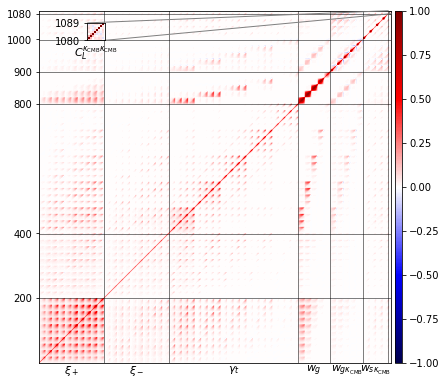

In [45]:
fig = plt.figure(figsize=(6.5, 6.5))
#ax = fig.add_axes([0.135, 0.125, 0.89, 0.88])

### Set data to show
### ================
#data_to_show = (cors[0][:Ndata_5x2pt,:Ndata_5x2pt] - cors[1][:Ndata_5x2pt,:Ndata_5x2pt])
#data_to_show = cors[3] - cors[1][:1094,:1094]
cor_test = cors[1].copy()
cor_test[:1089, :1089] -= cors[0][:1089, :1089]
cor_test[:1089, :1089] *= 1
data_to_show = cors[1]
max_range = np.max(abs(data_to_show))
print("max_range = %e"%max_range)
Ndata_6x2pt = Ndata_6x2pt_consext8
#Ndata_6x2pt = Ndata_6x2pt_agr2
### Plot corr mat
### =============
cb = plt.imshow(data_to_show, origin="lower", cmap='seismic', vmin=-max_range,vmax=max_range,)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(cb, cax=cax)

#print(ax.get_position())
#print(ax.get_position())

### Plot segmentations
### ==================
# xi_+
ax.axvline(Nss/2-0.5, lw=0.5, color='k')
ax.axhline(Nss/2-0.5, lw=0.5, color='k')
# xi_-
ax.axvline(Nss-0.5, lw=0.5, color='k')
ax.axhline(Nss-0.5, lw=0.5, color='k')
# gs
ax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs-0.5, lw=0.5, color='k')
# gg
ax.axvline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
# gk
ax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
# sk
ax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')

### Annotate probes
### ===============
fs = 11
Npad = -2
ax.text(Nss/2/2, Npad, 
        r'$\xi_+$', ha='center', va='top', fontsize=fs)
ax.text((Nss/2 + Nss)/2, Npad, 
        r'$\xi_-$', ha='center', va='top', fontsize=fs)
ax.text((Nss + Nss+Ngs)/2, Npad, 
        r'$\gamma_t$', ha='center', va='top', fontsize=fs)
ax.text((Nss+Ngs + Nss+Ngs+Ngg)/2, Npad, 
        r'$w_g$', ha='center', va='top', fontsize=fs)
ax.text((Ndata_3x2pt + Ndata_3x2pt+Ngk)/2, Npad, 
        r'$w_{g\kappa_\mathrm{CMB}}$', ha='center', va='top', fontsize=fs)
ax.text((Ndata_3x2pt+Ngk + Ndata_3x2pt+Ngk+Nsk)/2, Npad, 
        r'$w_{s\kappa_\mathrm{CMB}}$', ha='center', va='top', fontsize=fs)
ax.set_xticks([])
ax.set_yticks([Nss//2, Nss, Nss+Ngs, Ndata_3x2pt, Ndata_3x2pt+Ngk, Ndata_3x2pt+Ngk+Nsk])

### Zoom-in panel
### =============
axins = zoomed_inset_axes(ax, 6, 
                          bbox_to_anchor=(0.2, 0.98),
                         bbox_transform=ax.transAxes) # zoom = 6
axins.imshow(data_to_show, interpolation="nearest",
             origin="lower",cmap='seismic', vmin=-max_range,vmax=max_range,)
# sub region of the original image
x1, x2, y1, y2 = Ndata_5x2pt, Ndata_6x2pt, Ndata_5x2pt, Ndata_6x2pt
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([Ndata_5x2pt, Ndata_6x2pt])
axins.text((Ndata_3x2pt+Ngk+Nsk + Ndata_6x2pt)/2, Ndata_5x2pt+Npad, 
           r'$C^{\kappa_\mathrm{CMB}\kappa_\mathrm{CMB}}_L$', ha='center', va='top', fontsize=fs)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()

### If show data vector difference
### ==============================
show_datav_diff = False
if show_datav_diff:
    subax = fig.add_axes([0.14, 0.05, 0.88, 0.07])
    print(subax.get_position())
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                   s=1, label='tSZcontm-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff_tSZref[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                  s=1, label='ref-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[:Ndata_3x2pt], diff_treecorr[:Ndata_3x2pt], 
                  s=1, label='TreeCorr-Pub')
    subax.legend(loc='lower left')
    # xi_+
    subax.axvline(Nss/2-0.5, lw=0.5, color='k')
    # xi_-
    subax.axvline(Nss-0.5, lw=0.5, color='k')
    # gs
    subax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
    # gg
    subax.axvline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
    # gk
    subax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
    # sk
    subax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')
    subax.set_xlim(ax.get_xlim())


#plt.show()
#plt.tight_layout()
plt.savefig("CorrMat_CkkCkk_FFP10.png", dpi=300)

## TODO: 
- [x] why there's difference in the 3x2pt part? _Because of the integration niter and halo\_fast.c_
- [x] compare between Planck covmat and analytical covmat: Compared between $\Sigma$ from _Planck_ and analytical one without linear correction, consistant in general.

# CMB lensing convergence covmat: compare between Planck DR and CosmoLike

1.0669642857142858


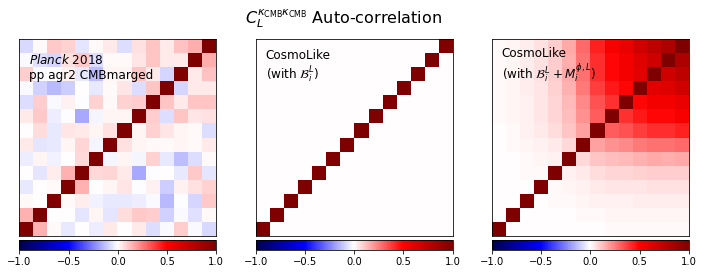

In [7]:
cov_merge = np.zeros((15,15))
cor_merge = np.zeros((14,14))

cov_kk_cosmolike = covs[1][Ndata_5x2pt:, Ndata_5x2pt:]
cov_kk_cosmolike_corr = covs[0][Ndata_5x2pt:, Ndata_5x2pt:]

Nvar, Nbins = 240, 14
hartlap_factor = (Nvar - Nbins - 2)/(Nvar - 1)
#hartlap_factor = 1
print(1/hartlap_factor)
cov_kk_planck_CMBmarg = np.genfromtxt("../cmblensrec/plancksmica/pp_agr2_CMBmarged/Ckk_bandpower_covariance.txt")
#cov_kk_planck_CMBmarg /= hartlap_factor
cov_kk_planck = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/PlanckLensingLikelihood/planck_lensing_2018/"+\
                             "smicadx12_Dec5_ftl_mv2_ndclpp_p_teb_agr2_cov.dat").reshape((14,14))*(np.pi/2)**2#/hartlap_factor

cor_kk_cosmolike = cov2cor(cov_kk_cosmolike)
cor_kk_cosmolike_corr = cov2cor(cov_kk_cosmolike_corr)
cor_kk_planck = cov2cor(cov_kk_planck)
cor_kk_planck_CMBmarg = cov2cor(cov_kk_planck_CMBmarg)


fig, axes = plt.subplots(1,3, figsize=(12,4))
fig.suptitle("$C^{\kappa_{\mathrm{CMB}}\kappa_\mathrm{CMB}}_L$ Auto-correlation", fontsize=16)
cb = axes[0].imshow(cor_kk_planck_CMBmarg, origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[0].text(0.05, 0.8, '$Planck$ 2018\npp agr2 CMBmarged', transform=axes[0].transAxes,
            fontsize=12)
axes[0].set(xticks=[], yticks=[])
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[1].imshow(cor_kk_cosmolike, origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[1].text(0.05,0.8,"CosmoLike\n(with $\mathcal{B}_i^L$)", transform=axes[1].transAxes,
            fontsize=12)
axes[1].set(xticks=[], yticks=[])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[2].imshow(cor_kk_cosmolike_corr, origin='lower', cmap='seismic', vmin=-1, vmax=1)
divider = make_axes_locatable(axes[2])
axes[2].text(0.05, 0.8, "CosmoLike\n(with $\mathcal{B}_i^L+M_i^{\phi,L}$)", transform=axes[2].transAxes,
            fontsize=12)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
axes[2].set(xticks=[], yticks=[])
plt.colorbar(cb, cax=cax, orientation='horizontal')

#plt.savefig("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/cov_kkkk_debug/cor_compare.png", dpi=300)
plt.show()

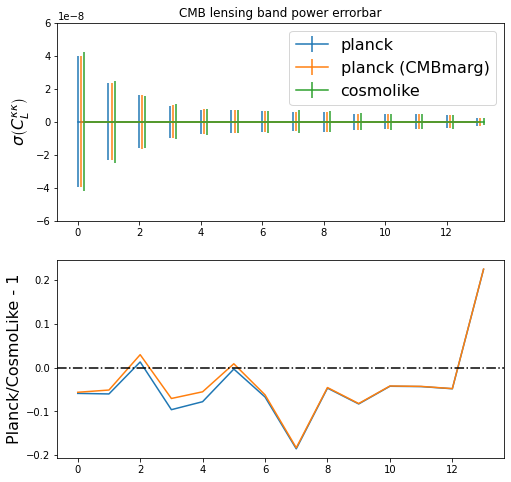

In [8]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

axes[0].errorbar(np.array(range(14)), np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_planck)), label='planck')
axes[0].errorbar(np.array(range(14))+0.1, np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_planck_CMBmarg)), label='planck (CMBmarg)')
axes[0].errorbar(np.array(range(14))+0.2, np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_cosmolike)), label='cosmolike')

axes[0].set_ylim([-6e-8, 6e-8])
axes[0].legend(fontsize=16)
axes[0].set_title("CMB lensing band power errorbar")
axes[0].set_ylabel(r'$\sigma\left(C^{\kappa\kappa}_L\right)$', fontsize=16)

axes[1].plot(range(14), np.sqrt(np.diagonal(cov_kk_planck))/(np.sqrt(np.diagonal(cov_kk_cosmolike)))-1,)
axes[1].plot(np.array(range(14)), np.sqrt(np.diagonal(cov_kk_planck_CMBmarg))/(np.sqrt(np.diagonal(cov_kk_cosmolike)))-1,)

axes[1].axhline(0,ls='-.',c='k')
axes[1].set_ylabel('Planck/CosmoLike - 1', fontsize=16)
plt.show()

# Building Covariance Matrix

We will use the covariance matrix from FFP10 simulation for the CMB lensing band-power auto-covariance, while use the analytical one for the remainings.

Any eigenvalues <= 0? True


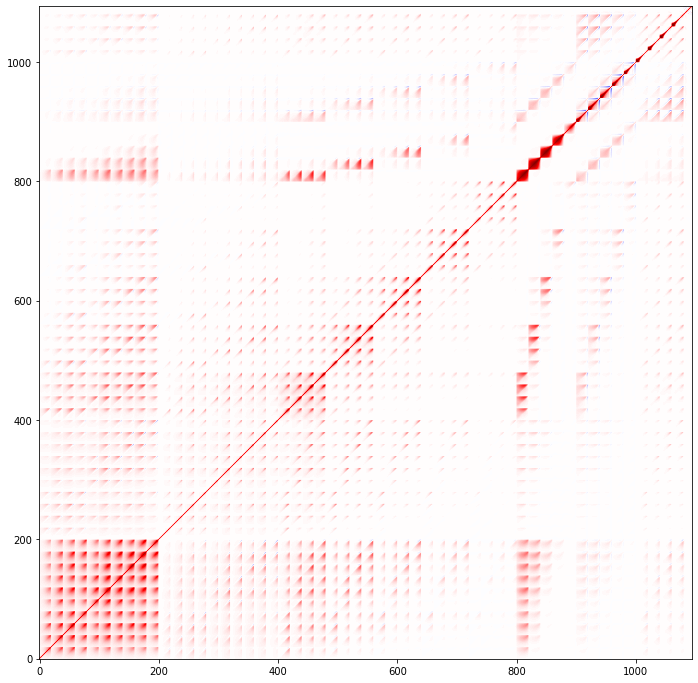

In [71]:
cov_cosmolike = covs[0].copy()
cov_cosmolike[Ndata_5x2pt:,Ndata_5x2pt:] = cov_kk_planck_CMBmarg
cor_cosmolike = cov2cor(cov_cosmolike)
# save the covariance matrix in which format?
with open(covs_dir+"/cov_y1xplanck_mix6x2pt_pp_p18cosmo_kk_sim", 'w') as fp:
    for i in range(cov_cosmolike.shape[0]):
        for j in range(i, cov_cosmolike.shape[1]):
            fp.write("%d %d %le\n"%(i, j, cov_cosmolike[i,j]))

ev = np.sort(np.linalg.eigvals(cov_cosmolike))
print(f'Any eigenvalues <= 0? {any(ev<=0)}')

fig = plt.figure(figsize=(12,12))
plt.imshow(cor_cosmolike, vmin=-1,vmax=1,cmap='seismic', origin='lower')
plt.show()

# Masked Covariance Positive-Definite?

Any eigenvalues <= 0? False


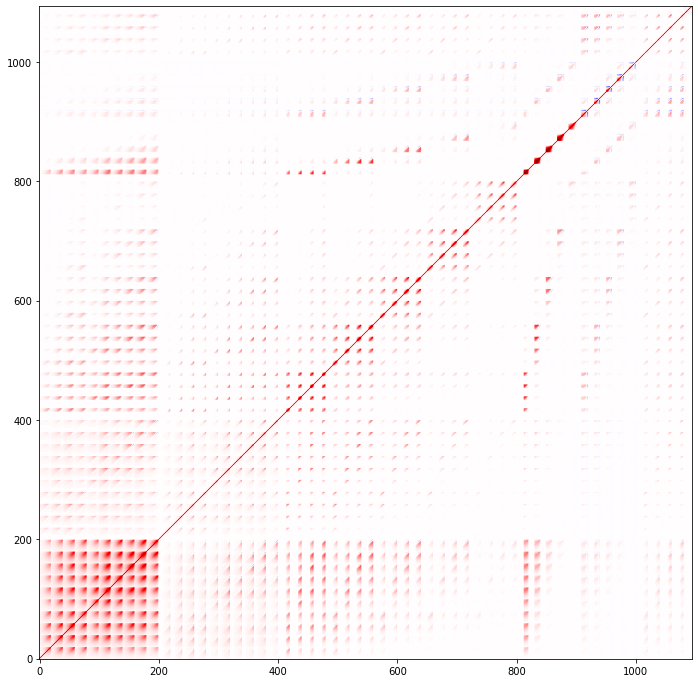

In [72]:
# read mask
cocoa_dir = "/home/u17/jiachuanxu/cocoa/Cocoa/projects"
mask = np.genfromtxt(cocoa_dir+'/desy1xplanck/data/xi_desy1xplanck_6x2pt_bp.mask')
cov_cosmolike_ma = np.zeros(cov_cosmolike.shape)

for i in range(cov_cosmolike.shape[0]):
    for j in range(cov_cosmolike.shape[1]):
        cov_cosmolike_ma[i,j] = cov_cosmolike[i,j]*mask[i,1]*mask[j,1]
        if (i==j) and (mask[i,1]*mask[j,1]<1e-5):
            cov_cosmolike_ma[i,j] = cov_cosmolike[i,j]

cor_cosmolike_ma = cov2cor(cov_cosmolike_ma)

ev = np.sort(np.linalg.eigvals(cov_cosmolike_ma))
print(f'Any eigenvalues <= 0? {any(ev<=0)}')

fig = plt.figure(figsize=(12,12))
plt.imshow(cor_cosmolike_ma, vmin=-1,vmax=1,cmap='seismic', origin='lower')
plt.show()

# [DEBUG] Test Linear Correction

Test the sign of CMB lensing band power linear correction offset. To do so, calculate $\sum M_i^{\phi,L}C_L^{\lappa\kappa}$ and compare with the extracted offset? 

In [15]:
invcov = LA.inv(cov)
a = np.sort(LA.eigvals(invcov[:,:]))
print("Eigenvalues range of the full invcov matrix: [{}, {}]".format(np.min(a), np.max(a)))
print("neg eigenvalues full invcov:")
for i in range(0,a.shape[0]):
    if (a[i]< 0.0): print(a[i])

Eigenvalues range of the full invcov matrix: [-3.02529240108774e+17, 1.1935301806862992e+17]
neg eigenvalues full invcov:
-3.02529240108774e+17
-1.7380148719713088e+17
-1.0899146021286371e+17
-3.003518766019656e+16
-1.4219757166158308e+16
-1.133614744582977e+16
-1.0408383542583398e+16
-152541069300632.8
-65286561056497.14
-17654489365148.74
-12964328221201.148
-2208408988185.1953


# [pass] Check likelihood difference between data vectors

In [105]:
# 2pt functions output
twopt_dir = "/home/u17/jiachuanxu/CosmoLike/2pt_measurements/data_test"

# data vector angular mask file


# 3x2pt data vectors measured by TreeCorr
datav_gg = twopt_dir+'/gg_%d_%d.txt'
datav_gs = twopt_dir+'/ggl_S%d_L%d.txt'
datav_ss = twopt_dir+'/shear_%d_%d.txt'

# gk, sk data vectors measured from planck reference smoothed map
datav_gk_tSZref = twopt_dir+'/gk_smooth_%d.txt'
datav_sk_tSZref = twopt_dir+'/sk_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-contaminated smoothed map
datav_gk_tSZcontm = twopt_dir+'/gk_SZctm_smooth_%d.txt'
datav_sk_tSZcontm = twopt_dir+'/sk_SZctm_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-deprojected smoothed map
datav_gk_tSZdeproj = twopt_dir+'/gk_SZdeproj_smooth_%d.txt'
datav_sk_tSZdeproj = twopt_dir+'/sk_SZdeproj_smooth_%d.txt'

In [127]:
gk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          ]
sk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
          ]
_DESY1_3x2pt_mask = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/2pt_meas"\
                                 "urements/data_test/xi_desy1_3x2pt_treecorr_test.mask")
DESY1_3x2pt_mask = np.zeros(Ndata)
DESY1_3x2pt_mask[:Ndata_3x2pt] = _DESY1_3x2pt_mask[:,1]

## 1. 6x2pt Data vector measured using Planck reference map and Planck tSZ-deprojected map

In [111]:
datav_tSZcontm = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZcontm = np.genfromtxt(datav_gk_tSZcontm%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = gk_tSZcontm['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZcontm = np.genfromtxt(datav_sk_tSZcontm%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = sk_tSZcontm['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff = datav_tSZcontm - datav_tSZdeproj
loglike_diff = -0.5*diff.T@invcov@diff
print("Difference in log(likelihood) between tSZ-contamintaed "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between tSZ-contaminated and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between tSZ-contamintaed and tSZ-deprojected gk+sk data vectors = -426.76
Difference in chi2 per dof between tSZ-contaminated and tSZ-deprojected gk+sk data vectors >= 4.74


## 2. 3x2pt Data vector measured using TreeCorr code and the public data vector

In [128]:
datav_treecorr = np.zeros(Ndata)
datav_public = np.zeros(Ndata)
_datav_treecorr = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_treecorr_test")
_datav_public = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_public")
datav_treecorr[0:Ndata_3x2pt] = _datav_treecorr[:,1]
datav_public[0:Ndata_3x2pt] = _datav_public[:,1]
# calculate difference in likelihood
diff_treecorr = (datav_treecorr - datav_public)*DESY1_3x2pt_mask
loglike_diff = -0.5*diff_treecorr.T@invcov@diff_treecorr
print("Difference in log(likelihood) between TreeCorr "\
      "and Public 3x2pt data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between TreeCorr and"\
      " public 3x2pt data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

Difference in log(likelihood) between TreeCorr and Public 3x2pt data vectors = -2.42
Difference in chi2 per dof between TreeCorr and public 3x2pt data vectors >= 0.03


In [112]:
datav_tSZref = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZref = np.genfromtxt(datav_gk_tSZref%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = gk_tSZref['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZref = np.genfromtxt(datav_sk_tSZref%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = sk_tSZref['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff_tSZref = datav_tSZref - datav_tSZdeproj
loglike_diff = -0.5*diff_tSZref.T@invcov@diff_tSZref
print("Difference in log(likelihood) between reference "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between reference and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between reference and tSZ-deprojected gk+sk data vectors = -559.73
Difference in chi2 per dof between reference and tSZ-deprojected gk+sk data vectors >= 6.22
